# **Solving a TSP problem using callbacks**

***tsp_callbacks.ipynb***

Solve an instance of the [Traveling Salesperson Problem (TSP)](https://en.wikipedia.org/wiki/Travelling_salesman_problem) with Xpress using callbacks and *NumPy* arrays. 

Generate random TSP data, then solve the problem using the FICO&reg; Xpress Optimizer library with the appropriate callback. Once the optimization is over (i.e. the time limit is reached or we find an optimal solution) the optimal tour is displayed using *matplotlib*.

*This example requires a full license of the FICO&reg; Xpress Optimizer. Click on [this link](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) for more information about trial and licensing options.*

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://community.fico.com/s/contentdocument/06980000002h0i5AAA) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress

## Standard formulation

Let's start with the standard formulation, where binary variables $use_{ij} \in \{0,1\}, \forall i,j \in \mathcal{N}$ represent the decision of whether the tour uses the arc $(i,j)$ (i.e. if we go from city $i$ to $j$) or not. An optimal tour can be found by solving:
$$
\min \sum_{i,j \in \mathcal{N}} dist_{ij} use_{ij}
$$

subject to:

* We have to enter and leave every city, and source node cannot be the same as the destination node: 
$$
\sum_{j \in \mathcal{N}} use_{ij} = 1, \quad \forall i \in \mathcal{N} \\
\sum_{j \in \mathcal{N}} use_{ji} = 1, \quad \forall i \in \mathcal{N} \\
use_{ii} = 0, \quad \forall i \in \mathcal{N}
$$

Where $dist_{ij}, \forall i,j \in \mathcal{N}$ represents the distance (or cost) associated with traveling on an arc $(i,j)$. We overlook subtour elimination constraints for now.

In [17]:
# FICO Xpress Optimizer - Python Interface
import xpress as xp
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import itertools

rndseed = 10

np.random.seed(rndseed)

'''Create random TSP problem data'''
n = 17
CITIES = range(n)  # set of cities: 0..n-1

np.random.seed(0)

X = 100 * np.random.rand(n)
Y = 100 * np.random.rand(n)

XY = (X, Y)

# Compute distance matrix
dist = np.ceil(np.sqrt ((X.reshape(n,1) - X.reshape(1,n))**2 +
                        (Y.reshape(n,1) - Y.reshape(1,n))**2))

# Create problem
p = xp.problem()

# Create variables as a square matrix of binary variables. Note
# the use of p.addVariables to ensure NumPy uses the Xpress operations for handling these vectors.
use = p.addVariables(n,n, vartype=xp.binary, name='x')

# Degree constraints
p.addConstraint(xp.Sum(use[i,:]) == 1  for i in CITIES)
p.addConstraint(xp.Sum(use[:,i]) == 1  for i in CITIES)

# Fix diagonals (i.e. city X -> city X) to zero
p.addConstraint(use[i,i] == 0 for i in CITIES)

# Objective function
p.setObjective(xp.Sum((dist * use).flatten()))

p.optimize()

FICO Xpress v9.5.3, Hyper, solve started 16:20:00, Feb 19, 2025
Heap usage: 449KB (peak 449KB, 138KB system)
Minimizing MILP noname using up to 20 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
        51 rows          289 cols          595 elements       289 entities
Presolved problem has:
        34 rows          272 cols          544 elements       272 entities
Presolve finished in 0 seconds
Heap usage: 601KB (peak 673KB, 138KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  Objective      [min,max] : [ 3.00e+00,  1.06e+02] / [ 3.00e+00,  1.06e+02]
Autoscaling applied standard scaling

Symmetric problem: generators: 1, support set: 272
 Number of orbits: 136, largest orbit: 2
 Row orbi

(<SolveStatus.COMPLETED: 3>, <SolStatus.OPTIMAL: 1>)

Now let's use the *matplotlib* and *networkx* Python packages to visualize the solution obtained by Xpress and check if there are any subtours:

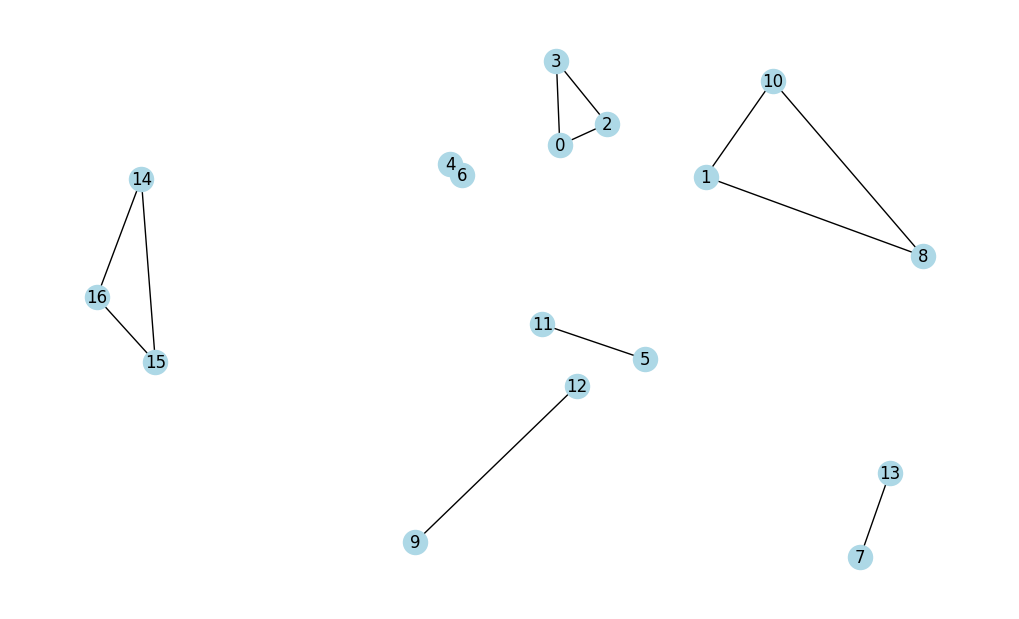

In [18]:
# Visualize solution using networkx and matplotlib

def plot_sol(p):

    # collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
    edges = []
    sol = p.getSolution(use) # get solution values
    for (i,j) in itertools.permutations(CITIES, 2):
        if sol[i,j] > 0.5: # variable is binary so > 0.5 --> is 1
            edges.append( (i,j) )

    # create dictionary with coordinates for each node to plot the graph 
    xy = {}
    for i in range(n):
        xy[i] = (X[i], Y[i])

    # make figure look nicer
    plt.figure(figsize=(10,6), dpi=100)

    # create empty graph
    optgraph = nx.Graph()

    # add edges
    optgraph.add_edges_from(edges)

    # draw the cities, with labels in the position xy (see when we read the instance)
    nx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

    # show drawing
    plt.show()

# Plot solution
if p.attributes.solstatus not in [xp.SolStatus.OPTIMAL, xp.SolStatus.FEASIBLE]:
    print("Solve status:", p.attributes.solvestatus.name)
    print("Solution status:", p.attributes.solstatus.name)
else:
    plot_sol(p)

As you can see, the solution contains subtours, and therefore it is not yet a valid solution for the problem yet. We need to add constraints that eliminate any such subtour.

A straightforward approach for formulating subtour elimination constraints is to add a constraint for each subtour contained in the set of all subtours $\mathcal{S}$ as follows:

$$
\sum_{i,j \in S} use_{ij} \leq |\mathcal{S}| - 1 \quad \forall \mathcal{S} \subsetneq \mathcal{N},\ |\mathcal{S}| \geq 2
$$

FICO Xpress v9.5.3, Hyper, solve started 16:20:05, Feb 19, 2025
Heap usage: 258MB (peak 258MB, 142KB system)
Minimizing MILP noname using up to 20 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
    131104 rows          289 cols     10027297 elements       289 entities
Presolved problem has:
    109310 rows          272 cols      6207312 elements       272 entities
Presolve finished in 31 seconds
Heap usage: 315MB (peak 603MB, 142KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.50e+01] / [ 1.00e+00,  9.00e+00]
  Objective      [min,max] : [ 3.00e+00,  1.06e+02] / [ 3.00e+00,  1.06e+02]
Autoscaling applied standard scaling

Symmetric problem: generators: 1, support set: 272
 Number of orbits: 136, largest orbit: 2
 Row orb

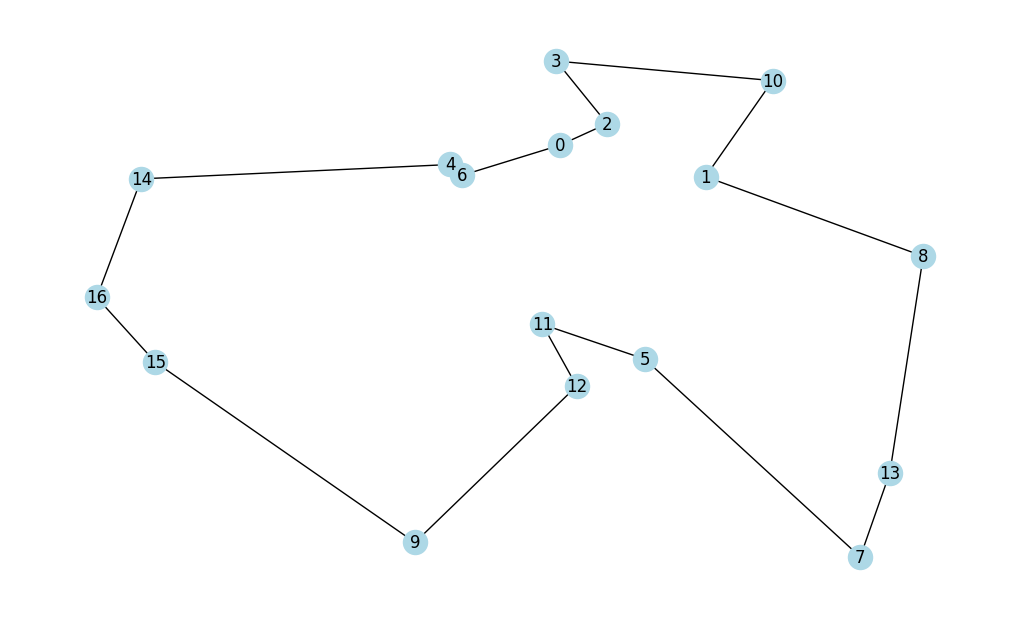

In [19]:
# FICO Xpress Optimizer - Python Interface (solution)

# Add subtour elimination constraints, solve and print
p.addConstraint(xp.Sum(use[i,j] for i in subset for j in subset) <= len(subset) - 1 
    for L in range(2,len(CITIES)) 
    for subset in itertools.combinations(CITIES, L)) 

p.optimize()

# Plot solution
plot_sol(p) 

The solution is now valid and complete, since an Hamiltonian tour (no subtours) has been formed. However, you could experience that the problem building and solving times are rather high for a TSP with only 17 cities.

This is due to the complete enumeration of all possible subtours, whose number grows exponentially with the instance size making the problem creation and solving times prohibitively long when problems grow just somewhat larger.

## Formulation using the Miller, Tucker, Zemlin subtour elimination constraints

Now we will model the same problem but using the Miller, Tucker, Zemlin subtour elimination constraints, which requires a new set of continuous variables:

$step_i$ = step at which node $i$ is visited, $\forall i = {2,...,|\mathcal{N}|}$

which are used as auxiliary variables for the formulation of subtour elimination constraints. Although a new set of real variables of size $|\mathcal{N}|$ is introduced, we are able to prevent all subtours by introducing a set of constraints of size $(|\mathcal{N}|-1)^2$, considerably reducing the problem size and complexity when comparing with the previous formulation:

$$
\min \sum_{i,j \in \mathcal{N}} cost_{ij} use_{ij}
$$

subject to:

* We have to enter and leave every city, and source node cannot be the destination node for any move: 
$$
\sum_{j \in \mathcal{N}} use_{ij} = 1, \quad \forall i \in \mathcal{N} \\
\sum_{j \in \mathcal{N}} use_{ji} = 1, \quad \forall i \in \mathcal{N} \\
use_{ii} = 0, \quad \forall i \in \mathcal{N}
$$
* Miller, Tucker, Zemlin subtour elimination constraints:
$$
step_j \geq step_i + 1 - (n-1)*(1 - use_{ij}), \forall i,j = {2,..,n}
$$

with $n = |\mathcal{N}|$.

FICO Xpress v9.5.3, Hyper, solve started 16:20:56, Feb 19, 2025
Heap usage: 526KB (peak 526KB, 213KB system)
Minimizing MILP noname using up to 20 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
       307 rows          306 cols         1331 elements       289 entities
Presolved problem has:
       274 rows          288 cols         1264 elements       272 entities
Presolve finished in 0 seconds
Heap usage: 735KB (peak 922KB, 213KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.60e+01] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.50e+01] / [ 9.38e-01,  1.00e+00]
  Objective      [min,max] : [ 3.00e+00,  1.06e+02] / [ 3.00e+00,  1.06e+02]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 22.1GB
Starting concurrent solve with dual 

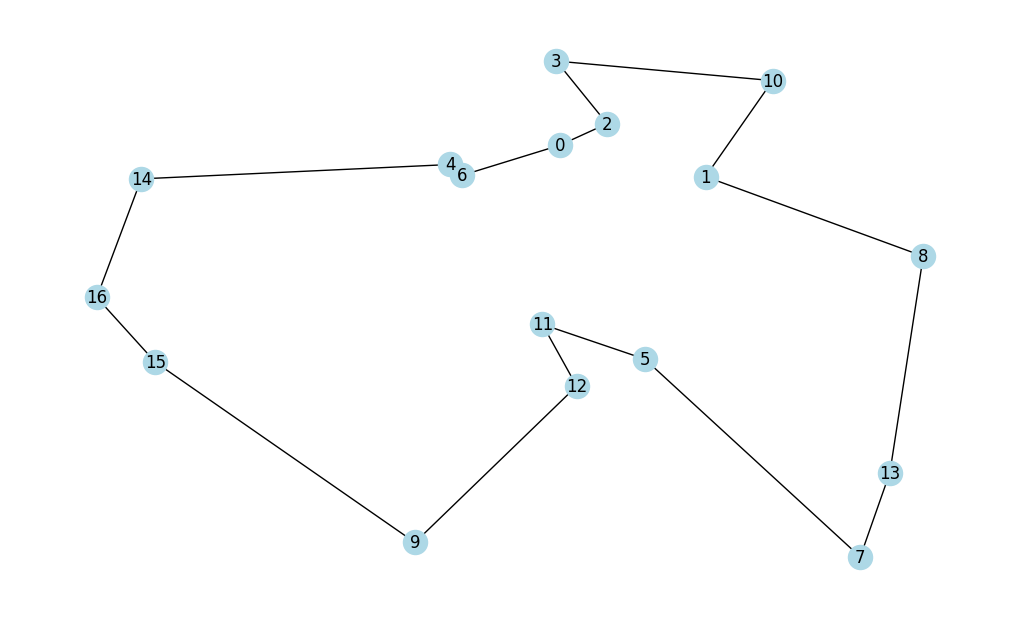

In [20]:
# FICO Xpress Optimizer - Python Interface (solution)

# Create problem
p = xp.problem()

# Create variables as a square matrix of binary variables. Note
# the use of p.addVariables to ensure NumPy uses the Xpress operations for handling these vectors.
use = p.addVariables(n,n, vartype=xp.binary, name='x')
step = p.addVariables(n, name='t')

# Degree constraints
p.addConstraint(xp.Sum(use[i,:]) == 1  for i in CITIES)
p.addConstraint(xp.Sum(use[:,i]) == 1  for i in CITIES)

# Fix diagonals (i.e. city X -> city X) to zero
p.addConstraint(use[i,i] == 0 for i in CITIES)

# Miller, Tucker, Zemlin subtour elimination constraints
p.addConstraint([step[j] >= step[i] + 1 - (n-1)*(1 - use[i,j]) for i in range(1,n) for j in range(1,n)])

# Objective function
p.setObjective (xp.Sum((dist * use).flatten()))

p.optimize()

# Plot solution
if p.attributes.solstatus not in [xp.SolStatus.OPTIMAL, xp.SolStatus.FEASIBLE]:
    print("Solve status:", p.attributes.solvestatus.name)
    print("Solution status:", p.attributes.solstatus.name)
else:
    plot_sol(p)  # print solution and cost

As you can confirm by looking at the graph and solver logs, this formulation yields the same solution as the previous one, but solves the problem much faster. Let's try to beat that in the next section!

## Using callbacks

Now let's try to speed up the problem creation and solving times even more by using **solver callbacks** to add only those subtour elimination constraints that are really needed during the solving process using the standard formulation.

Callback functions are user–defined routines to be specified to the Optimizer which are called at specific stages during the optimization process, prompting the Optimizer to return to the user's program before continuing with the solution algorithm. They are a useful tool particularly for Mixed Integer Programming (MIP) problems by allowing the user to interact with the solver during the solution search process (Branch-and-Bound). There are specific callbacks for other problem types, too.

[Using callback functions](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/chCallbacks.html) is simple: 
  * the user first defines a function (say *myfunction*) with a specific signature that is to be run every time the branch-and-bound reaches a well-specified point
  * secondly, the user specifies that the function is to be invoked every time the algorithm reaches a well-specified point calls a function (such as [problem.addcbpreintsol](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addcbpreintsol.html)) with *myfunction* as its argument
  * finally, the user runs the *optimize* command that launches the branch-and-bound, the simplex solver, or the barrier solver; it is while these are run that myfunction is called at the intended points (depending on the selected callback type, check the [list of callbacks accepted by the Xpress Optimizer](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/chapter5.html?scroll=section5002))

In this TSP example, we will relax (leave out) the subtour elimination constraints, and instead add a callback funtion that is triggered every time an integer (feasible) solution to the relaxed problem is found during the B&B process. By using the [problem.addcbpreintsol](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addcbpreintsol.html) solver callback, we will instruct the solver whether to accept (if no subtours) or discard (subtours exist) the solution found. In the latter case we add suitable subtour elimination constraints to the problem by calling the function [problem.addcuts](https://www.fico.com/fico-xpress-optimization/docs/dms2024-03/solver/optimizer/python/HTML/problem.addcuts.html) with the appropriate arguments. Therefore, the user-defined callback function needs to perform two main tasks:
  * checking whether a given solution forms a Hamiltonian tour
  * applying subtour elimination constraints to exclude the current node solution subtours from being found again

In [21]:
# FICO Xpress Optimizer - Python Interface

# Define callback function
def cb_preintsol(prob, data, soltype, cutoff):
    '''Callback for checking if solution is acceptable
    prob: Xpress problem object
    data: data object = number of cities
    soltype: type of MIP solution that has been found. 0 - LP relaxation is integer feasible, 1 - MIP solution found by a heuristic, 2 - MIP solution provided by the user
    '''

    n = data                             # number of cities
    xsol=prob.getCallbackSolution(use)   # get array with values of x variables in the current context-specific solution
    xsol = np.array(xsol).reshape(n,n)   # convert into matrix-shaped np array
    tour = np.argmax(xsol, axis=1)       # get indices of the max (non-zero) element in each column = resulting tour

    i = 0       # to store next city
    ncities = 1 # to count number of cities visited

    # Scan cities in order until we get back to 0 or the solution is wrong. 
    while tour[i] != 0 and ncities < n:
        ncities += 1
        i = tour[i]

    reject = False # at this point do not reject the solution
    if ncities < n:
        # The tour given by the current solution does not pass through
        # all the cities and thus contains subtours.
        # If soltype is non-zero, the solution was found by a heuristic
        # or provided by the user, so we reject it by setting reject=True without further branching.
        # If instead soltype is zero, the solution came from the LP relaxation  
        # of the current B&B node which was found to be integer feasible. In this case 
        # we will reject it by adding a cut that cuts off that solution.
        # Note that we must NOT set reject=True in that case because that would result in just
        # dropping the node, no matter whether we add cuts or not.
        if soltype != 0:
            reject = True
        else:
            # Obtain an order by checking the maximum of the variable matrix
            # for each row
            unchecked = np.zeros(n) # np array of zeros of size n to assign each city to a subtour
            nsubtour = 0            # to number and identify subtours

            # Initialize the vectors to be passed to problem.addcuts
            cut_mstart = [0]
            cut_ind = []
            cut_coe = []
            cut_rhs = []

            nnz = 0   # to mark the start of the variables indices for each cut
            ncuts = 0 # to count number of cuts (subtours)

            # while there are cities that are not assigned to a subtour
            while np.min(unchecked) == 0:
                nsubtour += 1                    # current subtour id
                firstcity = np.argmin(unchecked) # first city (index) in unchecked that is not assigned a subtour yet (i.e., =0)
                i = firstcity 

                # Scan cities in order for each subtour
                while True:
                    unchecked[i] = nsubtour  # mark city i as belonging to current subtour
                    i = tour[i]              # proceed to next city in the current subtour

                    if i == firstcity:       # if next city is the first city, subtour is finished, stop
                        break

                # Find indices of all variables with origin in this subtour and destination
                # outside this subtour. We will force the sum of those variables to be >= 1 
                # (i.e. subtour will be excluded after the cut is added). S is the set of cities
                # traversed by the subtour, compS is its complement (list of cities not contained in subtour S)
                S     = np.where(unchecked == nsubtour)[0].tolist()
                compS = np.where(unchecked != nsubtour)[0].tolist()
                indices = [i*n+j for i in S for j in compS] # convert into decision variables array indices

                # We need to presolve new row to adapt its data (rhs, column indices and row coefficients) for the presolved problem (instead of the original problem)
                mcolsp, dvalp = [], [] # lists to be populated by the 'presolverow' method

                # Presolve new row (cut) in order to add it to the presolved problem via addcuts
                drhsp, status = prob.presolverow(rowtype='G',
                                                    origcolind=indices,
                                                    origrowcoef=np.ones(len(indices)),
                                                    origrhs=1,
                                                    maxcoefs=prob.attributes.cols,
                                                    colind=mcolsp,
                                                    rowcoef=dvalp)

                nnz += len(mcolsp)
                ncuts += 1

                cut_ind.extend(mcolsp) # array which will be filled with the columns of the presolved row
                cut_coe.extend(dvalp)  # array which will be filled with the coefficients of the presolved row
                cut_rhs.append(drhsp)  # array containing the right hand side elements for the cuts
                cut_mstart.append(nnz) # array containing offset into the colind and cutcoef arrays indicating the start of each cut

            # add cuts
            if ncuts > 0:
                # call prob.addcuts and pass the necessary arguments to add the subtour elimination constraints (list of cuts)
                prob.addcuts(cuttype=[0] * ncuts,
                        rowtype=['G'] * ncuts,
                        rhs=cut_rhs,
                        start=cut_mstart,
                        colind=cut_ind,
                        cutcoef=cut_coe)            

    return (reject, None)

Now we will solve the problem with the standard formulation (without subtour elimination constraints), but **adding the callback function** and plotting the solution to validate the approach. 

FICO Xpress v9.5.3, Hyper, solve started 16:20:57, Feb 19, 2025
Heap usage: 449KB (peak 449KB, 154KB system)
Minimizing MILP noname using up to 20 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
        51 rows          289 cols          595 elements       289 entities
Presolved problem has:
        34 rows          272 cols          544 elements       272 entities
Presolve finished in 0 seconds
Heap usage: 601KB (peak 673KB, 154KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  Objective      [min,max] : [ 3.00e+00,  1.06e+02] / [ 3.00e+00,  1.06e+02]
Autoscaling applied standard scaling

Symmetric problem: generators: 1, support set: 272
 Number of orbits: 136, largest orbit: 2
 Row orbi

Heuristic search 'R' started
Heuristic search 'R' stopped
*          381.000000   381.000000      2                  0.00%       0      0
 *** Search completed ***
Uncrunching matrix
Final MIP objective                   : 3.810000000000000e+02
Final MIP bound                       : 3.810000000000000e+02
  Solution time / primaldual integral :      0.25s/ 64.020174%
  Number of solutions found / nodes   :         2 /         1
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max integer violation     (abs    ) :       0.0
OPTIMAL


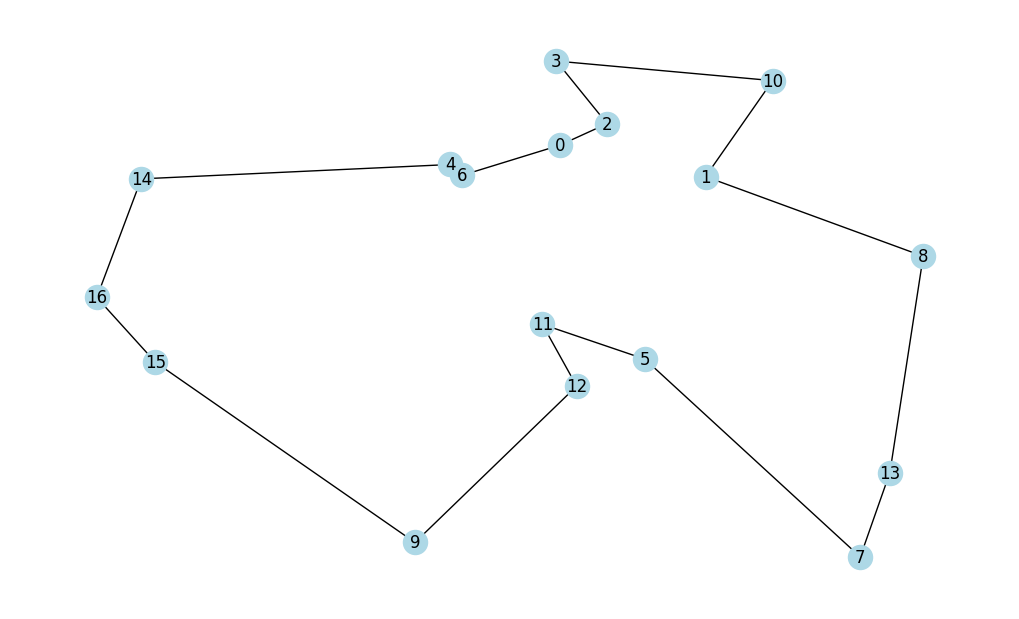

In [22]:
# FICO Xpress Optimizer - Python Interface

# Create problem
p = xp.problem()

# Create variables as a square matrix of binary variables. Note
# the use of p.addVariables to ensure NumPy uses the Xpress operations for handling these vectors.
use = p.addVariables(n,n, vartype=xp.binary, name='x')

# Degree constraints
p.addConstraint(xp.Sum(use[i,:]) == 1  for i in CITIES)
p.addConstraint(xp.Sum(use[:,i]) == 1  for i in CITIES)

# Fix diagonals (i.e. city X -> city X) to zero
p.addConstraint(use[i,i] == 0 for i in CITIES)

# Objective function
p.setObjective(xp.Sum((dist * use).flatten()))

# Add callback function
p.addcbpreintsol(cb_preintsol, n)

# Solve the problem and print solution
p.optimize()

print(p.attributes.solstatus.name)

if p.attributes.solstatus not in [xp.SolStatus.OPTIMAL, xp.SolStatus.FEASIBLE]:
    print("Solve status:", p.attributes.solvestatus.name)
    print("Solution status:", p.attributes.solstatus.name)
else:
    plot_sol(p)  # plot solution

As we can observe, the problem has been solved even faster than using the MTZ formulation, yielding the same solution and objective value in considerably less time, making the problem even more scalable. 

As am optional exercise,you can experiment with increasing the number the number of cities (*n* below) in the cell below and run the previous code cell again to see how high the number of cities <tt>n</tt> can go before the problem becomes computationally too expensive (let's say, takes more than 1 minute to solve to proven optimality).

In [23]:
'''Create random TSP problem data'''

n = 150

CITIES = range(n)  # set of cities: 0..n-1

np.random.seed(0)

X = 100 * np.random.rand(n)
Y = 100 * np.random.rand(n)

XY = (X, Y)

# Compute distance matrix
dist = np.ceil(np.sqrt ((X.reshape(n,1) - X.reshape(1,n))**2 +
                        (Y.reshape(n,1) - Y.reshape(1,n))**2))